In [5]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from mnist_train import Net
from utils.gpu_utils import restrict_GPU_pytorch
from utils.imagenet_utils import accuracy
from utils.dataloading_utils import MyIter, MyLoader
from new_tta_models import ImageDeferral, AugWeights, StandardTTA, Original, ClassWeights
from utee import selector
restrict_GPU_pytorch('1')

def get_cifar10_model():
    model_raw, _, _= selector.select('cifar10')
    return model_raw
model = get_cifar10_model()

Building and initializing cifar10 parameters


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU:1


Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(512, eps=1e-05

In [90]:
dataset = datasets.CIFAR10('../datasets', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
hflip_dataset = datasets.CIFAR10('../datasets', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(p=1),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
vflip_dataset = datasets.CIFAR10('../datasets', download=True, train=False, transform=transforms.Compose([
                           transforms.RandomVerticalFlip(p=1),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

n_examples = len(dataset)
subset_indices = np.arange(n_examples)
np.random.shuffle(subset_indices)
val_idxs = subset_indices[:int(len(subset_indices)/2)]
test_idxs = subset_indices[int(len(subset_indices)/2):]
batch_size = 512
n_augs = 3
orig_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, val_idxs), 
        batch_size=batch_size, shuffle=False)
hflip_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, val_idxs),
                                                batch_size=batch_size, shuffle=False)
vflip_val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, val_idxs),
                                                batch_size=batch_size, shuffle=False)
data_loader = MyLoader([orig_val_loader, hflip_val_loader, vflip_val_loader])


orig_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, test_idxs), 
        batch_size=batch_size, shuffle=False)
hflip_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(hflip_dataset, test_idxs),
                                                batch_size=batch_size, shuffle=False)
vflip_test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(vflip_dataset, test_idxs),
                                                batch_size=batch_size, shuffle=False)
test_data_loader = MyLoader([orig_test_loader, hflip_test_loader, vflip_test_loader])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Original model accuracy on CIFAR-10

In [91]:
orig_model = Original(model, 0)
orig_model.cuda('cuda:0')
orig_model.eval()
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = orig_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

87.24449920654297 99.51331329345703


## Standard TTA accuracy on CIFAR-10

In [92]:
stta_model = StandardTTA(model)
stta_model.cuda('cuda:0')
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = stta_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
    break
print(np.mean(test_acc1s), np.mean(test_acc5s))

82.8125 99.4140625


## Class-Weighted TTA accuracy on CIFAR-10

In [93]:
class_model = ClassWeights(model, n_augs, 10)
class_model.cuda('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
criterion.cuda('cuda:0')
optimizer = torch.optim.SGD(aug_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)

losses = []
acc1s = []
acc5s = []
epochs = 20
for epoch in range(epochs):
    for examples, target in data_loader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)
        output = class_model(examples)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc1s.append(acc1.item())
        acc5s.append(acc5.item())

In [94]:
class_model.eval()
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = class_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([392, 3, 10])
85.3276466369629 99.41565704345703


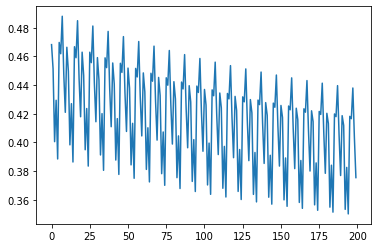

In [95]:
plt.plot(losses)

In [96]:
aug_model.sm(aug_model.w)

tensor([[0.3600, 0.3676, 0.4013, 0.3600, 0.3786, 0.3549, 0.3648, 0.3834, 0.3748,
         0.3525],
        [0.3487, 0.3673, 0.3858, 0.3640, 0.3756, 0.3521, 0.3702, 0.3740, 0.3816,
         0.3525],
        [0.2913, 0.2651, 0.2129, 0.2760, 0.2458, 0.2931, 0.2650, 0.2426, 0.2436,
         0.2950]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Learning augmentation-specific weights

In [97]:
aug_model = AugWeights(model, n_augs)
aug_model.cuda('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
criterion.cuda('cuda:0')
optimizer = torch.optim.SGD(aug_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)

losses = []
acc1s = []
acc5s = []
epochs = 20
for epoch in range(epochs):
    for examples, target in data_loader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)
        output = aug_model(examples)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc1s.append(acc1.item())
        acc5s.append(acc5.item())

torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([392, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([392, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([392, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([512, 3, 10])
torch.Size([392, 3, 10])


In [98]:
aug_model.eval()
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = aug_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))

87.24290466308594 99.51929168701172


In [99]:
aug_model.sm(aug_model.w)

tensor([[0.4629],
        [0.4322],
        [0.1049]], device='cuda:0', grad_fn=<SoftmaxBackward>)

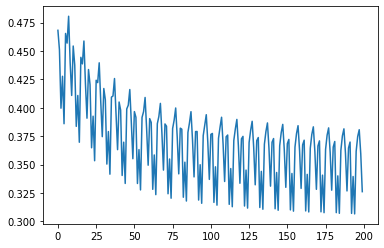

In [100]:
plt.plot(losses)

# Learning a mixture

In [101]:
model = Net()
model.load_state_dict(torch.load('../saved_models/mnist/mnist_cnn.pth'))
model.eval()
model.cuda('cuda:0')
def_model = ImageDeferral(model,n_augs, 10, 0, 1)
def_model.cuda('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
criterion.cuda('cuda:0')
optimizer = torch.optim.SGD(def_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)


losses = []
acc1s = []
acc5s = []
epochs = 10
for epoch in range(epochs):
    for examples, target in data_loader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)
        output = def_model(examples)
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        acc1s.append(acc1.item())
        acc5s.append(acc5.item())

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[512, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [ ]:
def_model.eval()
def_model.cuda('cuda:0')
model.cuda('cuda:0')
test_acc1s = []
test_acc5s = []
for examples, target in test_data_loader:
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = def_model(examples)
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    test_acc1s.append(acc1.item())
    test_acc5s.append(acc5.item())
print(np.mean(test_acc1s), np.mean(test_acc5s))